In [1]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np
LOG.propagate = False

In [192]:
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

2025-03-17 00:30:00,908 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:81:04:26:a3:64
2025-03-17 00:30:04,384 | INFO     |: Connected to c0:81:04:26:a3:64


/Users/akin/Desktop/Desktop/dev/fastrobots/ble_robot_1.2/ble_python/base_ble.py:104: FutureWarning: This method will be removed future version, pass the callback to the BleakClient constructor instead.
  self.client.set_disconnected_callback(self.disconnect_handler)


In [146]:
ble.disconnect()

2025-03-11 15:53:33,488 | INFO     |: Disconnected from A1C0DD95-B611-6CFA-AF80-6BCF50487F59


In [27]:
ble.send_command(CMD.PING, "")

In [28]:
s = ble.receive_string(ble.uuid['RX_STRING'])
print(s)

PONG


In [193]:
ble.send_command(CMD.SET_PID_GAINS, "0.08|0.0005|1.0")

In [194]:
ble.send_command(CMD.START_PID, "")

In [195]:
ble.send_command(CMD.STOP_PID, "")

2025-03-17 00:47:09,400 | INFO     |: Disconnected from A1C0DD95-B611-6CFA-AF80-6BCF50487F59


In [184]:
results = []

def notification_handler(uuid, byte_array):
    time, tof, pwm = ble.bytearray_to_string(byte_array).split('|')
    results.append([float(time), int(tof), int(pwm)])

ble.start_notify(ble.uuid['RX_STRING'], notification_handler)
ble.send_command(CMD.SEND_PID_DATA, "")

In [183]:
ble.stop_notify(ble.uuid['RX_STRING'])

In [185]:
print(results)

[[673698.0, 1307, -80], [673829.0, 1305, -80], [675131.0, 959, -53], [675260.0, 863, -45], [675782.0, 536, -19], [675810.0, 515, -17], [676030.0, 401, -8], [676160.0, 341, -3], [676387.0, 245, 3], [676613.0, 215, 6], [676646.0, 206, 7], [676964.0, 211, 6], [676989.0, 218, 6], [677512.0, 263, 2], [677539.0, 267, 2], [678065.0, 295, 0], [678194.0, 282, 0], [678313.0, 281, 1], [678338.0, 288, 0], [678373.0, 278, 1], [678496.0, 287, 0], [678627.0, 280, 1], [678945.0, 270, 1], [679166.0, 292, 0], [679298.0, 289, 0], [679325.0, 294, 0], [679351.0, 298, 0], [679371.0, 298, 0], [679393.0, 291, 0], [679417.0, 278, 1], [679736.0, 286, 0], [679764.0, 284, 0], [679788.0, 273, 1], [680105.0, 295, 0], [680135.0, 300, 0], [680156.0, 281, 1], [680771.0, 282, 1], [681885.0, 277, 1], [681919.0, 286, 0], [681953.0, 295, 0], [681974.0, 290, 0], [682192.0, 288, 0], [682214.0, 290, 0], [682236.0, 275, 1]]


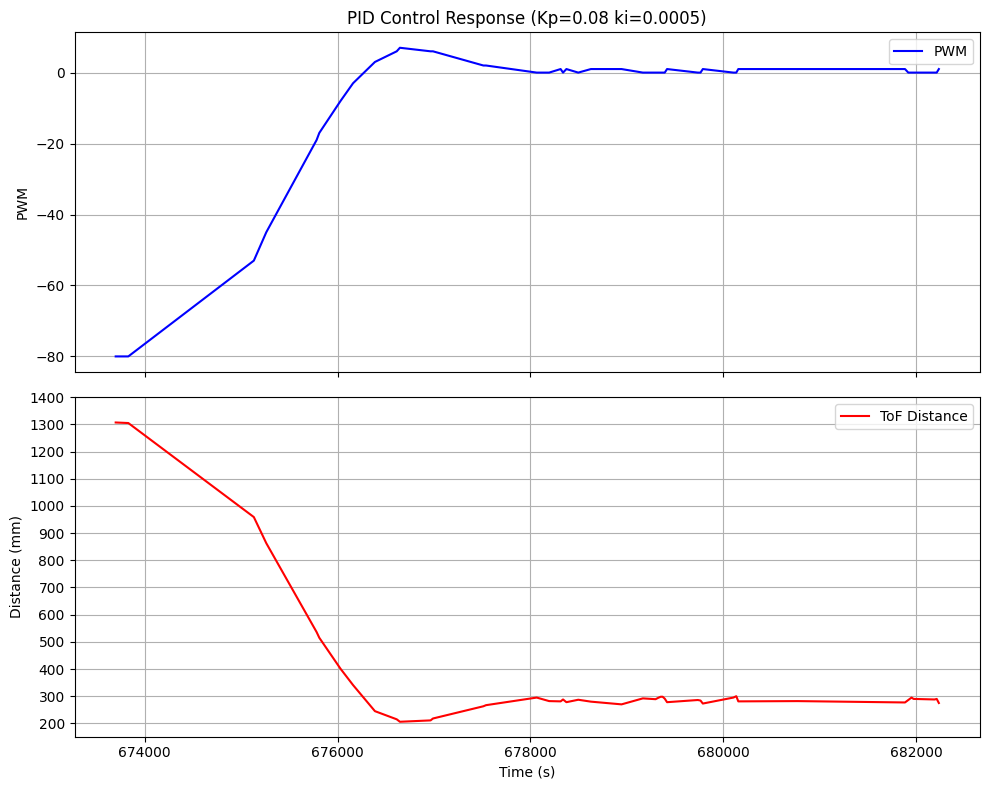

In [191]:
import matplotlib.pyplot as plt
import numpy as np

# Convert results to numpy array for easier handling
data = np.array(results)
time = data[:, 0]
tof = data[:, 1]
pwm = data[:, 2]

# Create figure with two subplots sharing x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot PWM vs Time
ax1.plot(time, pwm, 'b-', label='PWM')
ax1.set_ylabel('PWM')
ax1.set_title('PID Control Response (Kp=0.08 ki=0.0005)')
ax1.grid(True)
ax1.legend()

# Plot ToF vs Time
ax2.plot(time, tof, 'r-', label='ToF Distance')

ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Distance (mm)')
# Set y-axis ticks in steps of 100
ax2.yaxis.set_ticks(np.arange(min(tof) - min(tof) % 100, max(tof) + 100, 100))
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()